# L3: Topic Models
### 732A92/TDDE16 Text Mining
Students: mindu931, karzi360

### 1. Sampling

#### Requirement:  

"Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:"

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Init $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}$, the topic count vector of length ($K$) with respect to $\mathbf{z}$<br>

for $g \leftarrow 1$ __to__ _num_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ -= 1, $n^{(d)}_{d_i,z_i}$ -= 1, $n_{z_i}$ -= 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ += 1, $n^{(d)}_{d_i,z_i}$ += 1, $n_{z_i}$ += 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

In [9]:
import numpy, random, scipy.special
from tm3 import LDAGibbs
import matplotlib.pyplot as plt

class MyGibbs(LDAGibbs):
        
    def __init__(self, num_topics, docs_file_name, stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.docs = []
        ## Prepare set of stop words
        self.stop_words = set()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stop_words.add(word)
        self.read_documents(docs_file_name)
        self.initialize_matrices()
            
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stop_words:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
        
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics)) # n^w
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics)) # n^d
        self.topic_totals = numpy.zeros(self.num_topics) # n
        self.doc_totals = numpy.zeros(self.num_docs)
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = [random.randrange(self.num_topics) for token in doc['tokens']]
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for token, topic in zip(doc['tokens'], doc['topics']):
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
        ## Printout to check that everything is coherent
        #print(sum(sum(self.doc_topics)))
        #print(sum(sum(self.term_topics)))
        #print(sum(self.topic_totals))
        #print(sum(self.doc_totals))
        
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.logprobs = []
        for iteration in range(num_iterations): #iteration = 0
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def make_draw(self, alpha, beta):
        # Scan all docs
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]         
            for n, word in enumerate(doc['tokens']):
                      
                #Remove current topic indicator  zi  from  nw ,  nd  and  n 
                zi = doc['topics'][n]
                self.term_topics[word][zi] -= 1
                self.doc_topics[doc_id][zi] -= 1
                self.topic_totals[zi] -= 1

                #Compute the unnormalized probability of each topic indicator
                p = numpy.zeros(self.num_topics)
                for i in range(self.num_topics):
                    component1 = alpha + self.doc_topics[doc_id][i]
                    component2 = beta + self.term_topics[word][i]
                    component3 = self.num_topics*beta + self.topic_totals[i]
                    this_p = component1*(component2/component3) 
                    p[i] = this_p

                #Sample the topic indicator
                p = p/sum(p)     
                new_topic = numpy.random.choice(self.num_topics, size=1, p=p)[0]
                
                #Add the new topic indicator  zi  to  nw ,  nd  and  n  
                doc['topics'][n] = new_topic
                self.term_topics[word][new_topic] += 1
                self.doc_topics[doc_id][new_topic] += 1
                self.topic_totals[new_topic] += 1
                
        #super().make_draw(alpha, beta)
            
    def print_topics(self, j):
        print('Here is the top largest count in each topic')
        #Scan all topic
        for topic in  range(self.num_topics) :
            print('Topic {}'.format(topic))
            
            #Sorted and take the top j
            id_sorted = numpy.argsort(self.term_topics[:,topic])
            top_sorted = id_sorted[-j:]
            
            #List of result
            result = []
            for i in top_sorted :
                result.append(self.vocab[i])
            print(result)
        
        #super().print_topics(j)
    
    def plot(self):
        plt.plot(self.logprobs)
        plt.ylabel("Log marginal posterior")
        plt.xlabel("Number of iterations")
        plt.show()
        
        #super().plot()            
    
    def compute_logprob(self, alpha, beta):
        #K is the number of topics
        #V is the vocabulary size
        #D is the number of documents
        K = self.num_topics
        V = self.num_terms
        D = self.num_docs

        
        KV = K*V
        DK = D*K
        Vb = V*beta
        Ka = K*alpha

        lg = scipy.special.gammaln
        
        #We break the big equation to small components. Calculate each component and take the sum.
        component1 = K * lg(Vb)
        component2 = -KV * lg(beta)
        component3 = 0
        for i in range(K):
            for j in range(V):
                component3 = lg(self.term_topics[j][i] + beta) + component3

        component4 = 0
        for i in range(K):
            temp = 0
            for j in range(V):
                temp += self.term_topics[j][i]
            component4 += lg(temp + beta)
        component4 *= -1

        component5 = D * lg(Ka)
        component6 = -DK * lg(alpha)
        
        
        component7 = 0
        for i in range(D):
            for j in range(K):
                component7 += lg(self.doc_topics[i][j] + alpha)

        component8 = 0
        for doc in range(D):
            temp = 0
            for topic in range(K):
                temp += self.doc_topics[doc][topic]
            component8 += lg(temp + alpha)
        component8 *= -1
    
        result = component1 + component2 + component3 + component4 + component5 + component6 + component7 + component8
        
        return result
        #return super().compute_logprob(alpha, beta)
        
        
    def new_speech(self, alpha = 0.5, N=20): 
        # Function for taking the word
        def sample_word(p):
            return numpy.random.choice(self.num_terms, size=1, p=p)[0]
        
        speech = []
        theta = numpy.random.dirichlet(alpha = [0.5] * self.num_topics)
        
        #Fill word for all slot
        for i in range(N):
            k = numpy.random.choice(10, 1, p = list(theta))[0]
            prob_k = self.term_topics[:,k]/sum(self.term_topics[:,k])
            word = sample_word(p=prob_k)
            
            for voc in self.vocab_ids.keys():
                if self.vocab_ids[voc] == word :
                    speech.append(voc)

        return " ".join(speech)
        

We take the `sotu_1975_200.txt` and `stoplist_en.txt` as the input file. Here is the result with 100 topic and 100 iterations

In [10]:
num_topics = 10
num_iterations = 200

model = MyGibbs(num_topics, '/home/TDDE16/labs/l3/data/sotu_1975_2000.txt', '/home/TDDE16/labs/l3/data/stoplist_en.txt')
model.run(num_iterations)

Read 2898 documents with a total of 8695 terms
iteration 0, -725590.482310727
iteration 1, -687500.5938956391
iteration 2, -668294.3717353286
iteration 3, -657097.8585887547
iteration 4, -649745.5027851352
iteration 5, -643392.7583052616
iteration 6, -638206.8300617554
iteration 7, -633813.5014201018
iteration 8, -630577.4610995585
iteration 9, -627281.4815653963
iteration 10, -624366.6516234361
iteration 11, -621688.5414186681
iteration 12, -619545.2640465468
iteration 13, -617159.4015364915
iteration 14, -615108.30541198
iteration 15, -613493.6139034692
iteration 16, -612037.2553402497
iteration 17, -610670.8394845093
iteration 18, -609575.6771838386
iteration 19, -608379.6356210681
iteration 20, -607068.1339002295
iteration 21, -605673.1101860544
iteration 22, -604460.813512193
iteration 23, -603361.1338608512
iteration 24, -602507.7413009021
iteration 25, -601416.6387616361
iteration 26, -600568.863526013
iteration 27, -600211.5626317195
iteration 28, -598944.855982751
iteration 29

### 2. Top terms
Here is the the top `10` largest counts in $n(w)$ by row. This is the most probable word types in each topic.

In [11]:
model.print_topics(10)

Here is the top largest count in each topic
Topic 0
['development', 'system', 'legislation', 'program', 'policy', 'congress', 'programs', 'government', 'federal', 'administration']
Topic 1
['tax', 'federal', 'program', '000', 'congress', 'billion', 'million', 'percent', 'year', 'years']
Topic 2
['community', 'parents', 'america', 'education', 'give', 'schools', 'make', 'work', 'people', 'children']
Topic 3
['government', 'economic', 'inflation', 'spending', 'jobs', 'security', 'economy', 'growth', 'tax', 'budget']
Topic 4
['days', 'time', 'chamber', 'house', 've', 'america', 'years', 'president', 'people', 'tonight']
Topic 5
['system', 'americans', 'people', 'year', 'reform', 'work', 'welfare', 'congress', 'care', 'health']
Topic 6
['future', 'american', 'rights', 'peace', 'human', 'people', 'freedom', 'nation', 'world', 'america']
Topic 7
['future', 'tonight', 'world', 'america', 'government', 'years', 'union', 'american', 'state', 'people']
Topic 8
['production', 'america', 'century'

### 3. Explore the data


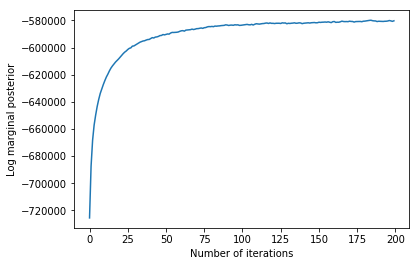

In [12]:
%matplotlib inline
model.plot()


We run the the State of the Union corpus until convergence with 10 topics, and plot the log marginal posterior by the number of iterations.
It seems that it will convergence after 100 interations.  
Based on the top 10 words of each topic. I guess that all topics talk about the problems of USA like work, economic, health, war, education... 


### 4. Simulate a new State of the Union speech

We write the `new_speech` function of `MyGibbs` class to simulate our document. Here is the result:

In [13]:
model.new_speech(0.5, 100)

'morning means frontiers union states world propose carry million pay deliver war independence american jobs detroit hope 000 head turn dramatically friends half growth proposing spending savings rate alert made general percent substantially lifeblood governments child dollar enter voice home made making pays blockade tonight business shocks sentences watts living growing graduating savings secret fails school home answer expanded big rates college neighbors hands loved challenge birthdays bonuses disappeared chamber make promote propose make illegal based conservation 1982 people total budget close prices times millions dropped vital stability planned moment teacher lock turned passed government decline running national low jobs'

The result seem not make any sense. The first reason is the generated document doesn't have any stop words, which make it difficult for understanding. Futhermore, words are choosen randomly. So They don't connected with the pervious words, which lead to the meanningless of the document.

### Bonus assignment:

 Implement the `compute_logprob` function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).